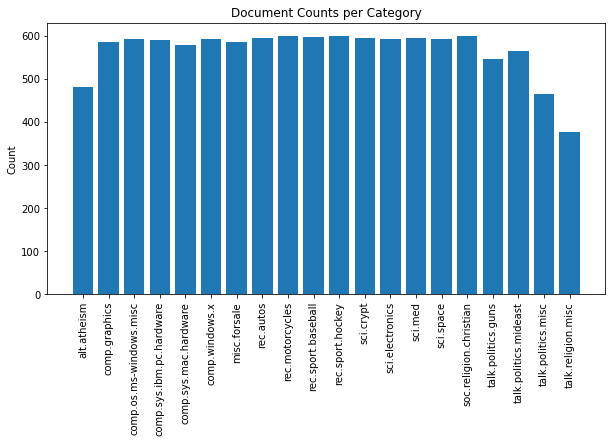

In [2]:
#Q1
import numpy as np
np.random.seed(42)
import random
random.seed(42)

from matplotlib import pyplot as plt
from sklearn.datasets import fetch_20newsgroups

plt.rcParams['figure.figsize'] = [10,5]

twenty_plot = fetch_20newsgroups(subset='train')
labels = twenty_plot.target_names

y = list(range(20))
for i in range(20):
    y[i] = np.count_nonzero(twenty_plot.target == i)

plt.bar(labels,y)
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Document Counts per Category")
plt.show()

In [11]:
#Q2
#Questions for TA:
#random_state for dataset fetch? None or 42? 42 used in discussion but project doc says None

import nltk
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from nltk.corpus import stopwords

categories = ['comp.graphics', 'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles',
'rec.sport.baseball', 'rec.sport.hockey']

lemur = nltk.wordnet.WordNetLemmatizer()

#Vectorizer
analyzer = CountVectorizer().build_analyzer()
tfidf_transformer = TfidfTransformer()

#Download dataset
train_dataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = 42) #should 42 be None?
test_dataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = 42)

combined_stopwords = set.union(set(stopwords.words('english')),set(punctuation))

def penn2morphy(penntag):
    morphy_tag = {'NN':'n', 'JJ':'a','VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(text):
    return [lemur.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(text)]

#Updated analyzer to avoid counting digits and punctuation
def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not word.isdigit())

count_vect = CountVectorizer(min_df=3,analyzer=stem_rmv_punc, stop_words='english')

corpus = [
    'This is the first document.',
    'This is the second second document.',
    'And the third one.',
    'Is this the first document?',
]

#X_train_counts = count_vect.fit_transform(corpus)

X_train_counts = count_vect.fit_transform(train_dataset.data)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = count_vect.transform(test_dataset.data)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

print("X_train shape: ", X_train_tfidf.shape)
print("X_test shape: ", X_test_tfidf.shape)



X_train shape:  (4732, 16466)
X_test shape:  (3150, 16466)


In [12]:
#Q3
#Questions for TA:
#random_state for nmf and trunc svd? 0 or 42? 

from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.utils.extmath import randomized_svd

trunc_svd = TruncatedSVD(n_components=50, random_state=0)
X_train_lsi = trunc_svd.fit_transform(X_train_tfidf)
X_test_lsi = trunc_svd.transform(X_test_tfidf)

#Get trunc svd matrices
#https://stackoverflow.com/questions/31523575/get-u-sigma-v-matrix-from-truncated-svd-in-scikit-learn
U, Sigma, VT = randomized_svd(X_train_tfidf, n_components=50, random_state=0)
Sigma = np.diag(Sigma) #Make sigma values a diag matrix rather than nx1

nmf_model = NMF(n_components=50, init='random', random_state=0)
X_train_nmf = nmf_model.fit_transform(X_train_tfidf)
X_test_nmf = nmf_model.transform(X_test_tfidf)
H = nmf_model.components_
error_lsi = np.sum(np.array(X_train_tfidf - U.dot(Sigma.dot(VT)))**2)
error_nmf = np.sum(np.array(X_train_tfidf - X_train_nmf.dot(H))**2)

print('LSI Train error: ', error_lsi)
print('NMF Train error: ', error_nmf)

print('LSI Train shape: ', X_train_lsi.shape)
print('LSI Test shape: ', X_test_lsi.shape)
print('NMF Train shape: ', X_train_nmf.shape)
print('NMF Test shape: ', X_test_nmf.shape)

LSI Train error:  4099.651344825857
NMF Train error:  4143.541730848815
LSI Train shape:  (4732, 50)
LSI Test shape:  (3150, 50)
NMF Train shape:  (4732, 50)
NMF Test shape:  (3150, 50)


C:\Users\Zoe\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Soft margin prediction stats:
              precision    recall  f1-score   support

           0       1.00      0.34      0.50      1560
           1       0.61      1.00      0.75      1590

    accuracy                           0.67      3150
   macro avg       0.80      0.67      0.63      3150
weighted avg       0.80      0.67      0.63      3150

Hard margin prediction stats:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1560
           1       0.96      0.98      0.97      1590

    accuracy                           0.97      3150
   macro avg       0.97      0.97      0.97      3150
weighted avg       0.97      0.97      0.97      3150



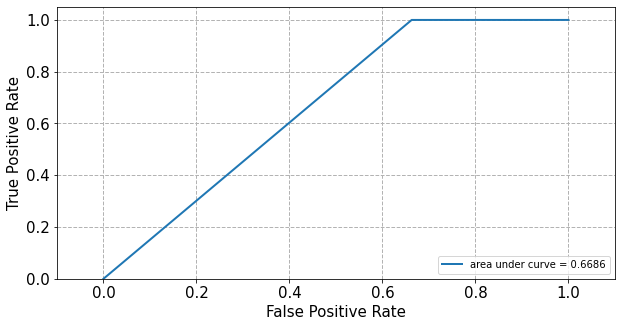

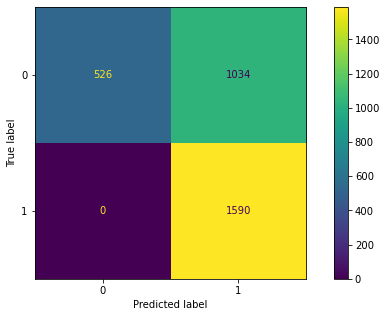

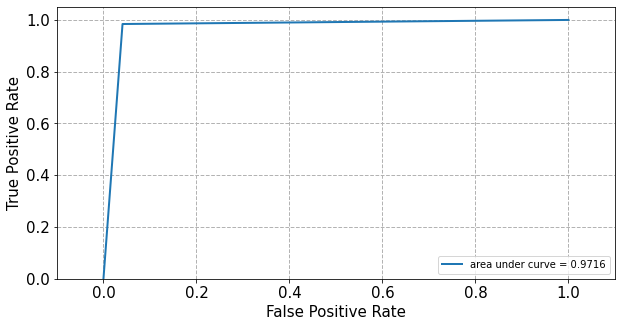

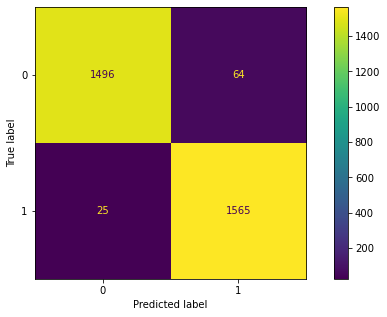

In [15]:
#Q4
from sklearn.svm import LinearSVC
from sklearn import metrics

#Start by changing to binary classification
train_targets_bin = train_dataset.target.copy()
for i in range(len(train_targets_bin)):
    if train_dataset.target[i] in [0,1,2,3]:
        train_targets_bin[i] = 0
    else:
        train_targets_bin[i] = 1
        
test_targets_bin = test_dataset.target.copy()
for i in range(len(test_targets_bin)):
    if test_dataset.target[i] in [0,1,2,3]:
        test_targets_bin[i] = 0
    else:
        test_targets_bin[i] = 1

#Train hard and soft margin SVCs - using LSI data per instructions - then get stats
soft_margin_SVC = LinearSVC(C=0.0001).fit(X_train_lsi, train_targets_bin)
soft_margin_prediction = soft_margin_SVC.predict(X_test_lsi)

hard_margin_SVC = LinearSVC(C=1000).fit(X_train_lsi, train_targets_bin)
hard_margin_prediction = hard_margin_SVC.predict(X_test_lsi)

fpr_soft, tpr_soft, thresholds_soft = metrics.roc_curve(test_targets_bin, soft_margin_prediction, pos_label=1)
fpr_hard, tpr_hard, thresholds_hard = metrics.roc_curve(test_targets_bin, hard_margin_prediction, pos_label=1)

#I stole this helper function from the discussion notebook!
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = metrics.auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)
        
#Show the stats for our model (part 1 of question)       
plot_roc(fpr_soft,tpr_soft)
metrics.plot_confusion_matrix(soft_margin_SVC, X_test_lsi, test_targets_bin)
print("Soft margin prediction stats:")
print(metrics.classification_report(test_targets_bin,soft_margin_prediction))

plot_roc(fpr_hard,tpr_hard)
metrics.plot_confusion_matrix(hard_margin_SVC, X_test_lsi, test_targets_bin)
print("Hard margin prediction stats:")
print(metrics.classification_report(test_targets_bin,hard_margin_prediction))

#hard margin is much better than soft!

Non-regularized logistic classifier stats:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1560
           1       0.97      0.98      0.97      1590

    accuracy                           0.97      3150
   macro avg       0.97      0.97      0.97      3150
weighted avg       0.97      0.97      0.97      3150



C:\Users\Zoe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


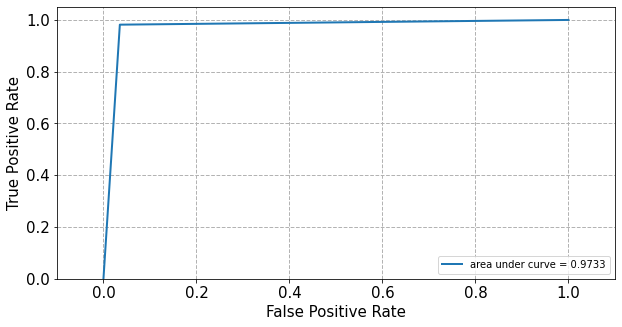

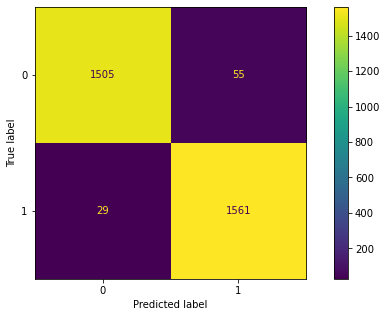

In [16]:
#Q5 
from sklearn.linear_model import LogisticRegression

#C is "Inverse of regularization strength", so a really big value approximates no regularization
log_class_no_reg = LogisticRegression(C=99999999).fit(X_train_lsi, train_targets_bin)
log_class_no_reg_prediction = log_class_no_reg.predict(X_test_lsi)

fpr, tpr, threshold = metrics.roc_curve(test_targets_bin, log_class_no_reg_prediction, pos_label=1)

plot_roc(fpr,tpr)
metrics.plot_confusion_matrix(log_class_no_reg, X_test_lsi, test_targets_bin)
print("Non-regularized logistic classifier stats:")
print(metrics.classification_report(test_targets_bin,log_class_no_reg_prediction))